In [103]:
from collections import namedtuple
from igraph import Graph, plot, layout, Plot
%config InlineBackend.figure_format = 'png'

# BST implementation

Here's a simplified implementation of a Binary Search Tree. 
We will use it as a starting point for our AVL implementation.

In [136]:
class Node(object):
    def __init__(self, key):
        # node key - this is the value we compare to determine where 
        # the node should be inserted.
        self.key     = key
        # left child (can be none if no child)
        self.left    = None
        # right child (can be none if no child)
        self.right   = None
        
def BST_insert(where, key):
    """Inserts a node in a binary tree"""
    if where is None:
        # if we found a branch pointing to none, it means we
        # can insert the node here
        return Node(key)
    elif key <= where.key:
        # try inserting the node somewhere in the left subtree
        where.left = BST_insert(where.left, key)
    elif key > where.key:
        # try inserting the node in the right subtree
        where.right = BST_insert(where.right, key)
    return where

def BST_draw(node, g, display_height=False):
    """This method allows us to draw a binary tree.
    
    Don't worry about the implementation."""
    if node is None:
        return
    
    if node.left is not None:
        BST_draw(node.left,  g, display_height)
        left_id = str(id(node.left))
        left_color = "black"
    else:
        g.add_vertex(shape=0,)
        left_id = len(g.vs) - 1
        left_color = "#00000000"
    
    if node.right is not None:
        BST_draw(node.right, g, display_height)
        right_id = str(id(node.right))
        right_color = "black"
    else:
        g.add_vertex(shape=0,)
        right_id = len(g.vs) - 1
        right_color = "#00000000"

    label = str(node.key)
    if display_height:
        label = label + ' (height: %d)' % (node.height,)
        
    g.add_vertex(name=str(id(node)), label=label, 
                 shape="rectangle", color="lightblue")
    if node.left is not None or node.right is not None:
        g.add_edge(str(id(node)), left_id, color=left_color)
        g.add_edge(str(id(node)), right_id, color=right_color)
        
            
class BST(object):
    def __init__(self):
        """This is a BST wrapper class.
        
        Its main function is keeping track of the root and 
        initiating recursive calls."""
        self.root = None
    
    def insert(self, key):        
        self.root = BST_insert(self.root, key)
    
    def draw(self, display_height=False):
        margin, width, height = 50, 500, 300
        figure = Plot(bbox=(width, height))
        
        g = Graph()
        if self.root is not None:
            BST_draw(self.root, g, display_height)
            root_id = [i for i, node in enumerate(g.vs) if g.vs[i]['name'] == str(id(self.root))]
            assert len(root_id) == 1
            figure.add(g, layout = Graph.layout_reingold_tilford(g, mode="in", root=root_id), 
                        bbox=(margin, margin, width-margin, height - margin), vertex_size=30)
            return figure

# What's wrong with Binary Search Trees?

AVL trees extend the Binary Search Trees, to provide better complexity guarantes. Both datastructures can implement any of insertion, deletion, successor etc. in $O(h)$. The difference is the fact that in case of BST height can be $O(n)$, while AVL guarantees height $O(lg \ n)$. Let's try to understand this on an example:

Inserting sorted sequence into BST results in an unbalance datastructure.

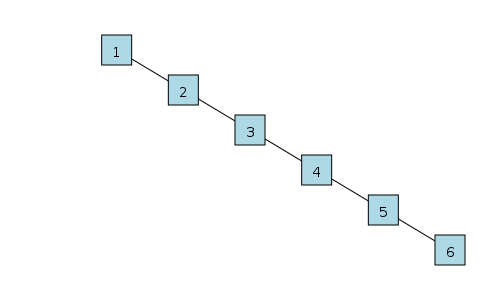

In [138]:
tree = BST()
for el in [1,2,3,4,5,6]:
    tree.insert(el)
tree.draw()

What we would like to see is a tree that looks more like this:

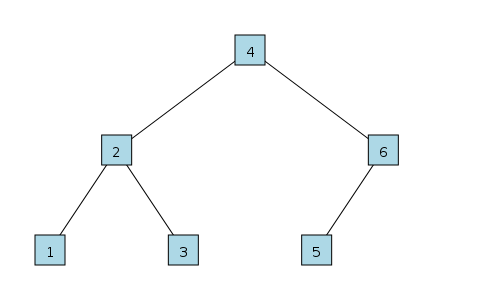

In [139]:
tree = BST()
for el in [4,2,1,3,6,5]:
    tree.insert(el)
tree.draw()

# AVL trees

We can see from above example that changing the order of insertions can result in balanced three. However the point of BSTs is that we want to be able to update it online, as the updates arrive, without necessarily knowing the elements we are going to insert in the future. AVL provide best of both worlds - they support online updates, and the updates always result in balanced trees. 

### AVL invariant

Let $X$ be arbitrary node in AVL tree. Let $X_L$, $X_R$ be left and right children of $X$ respectively. Furthermore let $H_X$ be height of subtree rooted in $X$. AVL trees satisfy the following invariant:

$$ \left| H_{X_L} - H_{X_L} \right| \leq 1 $$

It is satisfied before and after all the operations that we perform on an AVL tree. In this recitation we will implement AVL insertion that is capable of maintaining that invariant. Notice that BST by default does not satisfy this invariant (make sure you understand why).

### AVL height

First step on our journey to implement AVL trees is to keep track of tree height. To implement it we first need to make sure that we understand what $H_X$ actually means. Let's look at a definition:

$$
H_X=
\begin{cases}
-1                &\text{ if } X = 0 \\
max(H_L, H_R) + 1 &\text{otherwise}
\end{cases}
$$

Notice that this definition in particular implies that heigh of a leaf is $0$. Alternative definition of height is the maximum number of edges we need to traverse to get from a node its some leaf (and $-1$ is a special case for convenience).

One we to keep track of height is to calculate it every time in $O(h)$ complexity. This is a correct solution, but as we will soon find out, we will use the information about height too often for the extra $O(h)$ cost. Alternative solution is for every tree to store its height. Then all we need to do is to correct it, when tree changes. Let's see how to implement it:

In [151]:
class Node(object):
    def __init__(self, key):
        self.key     = key
        self.left    = None
        self.right   = None
        # here it is!
        self.height  = 0
        
    def recompute_height(self):
        """Updates the height variable.
        
        Should be run every time subtree changes.
        Assumes children height values are correct."""
        # we assure left and right already has correct height computed.
        # if they don't exists we assume height is -1
        left_height  = self.left.height  if self.left  is not None else -1
        right_height = self.right.height if self.right is not None else -1
        # height computed using formula from above
        self.height = max(left_height, right_height) + 1
        
    # This will be useful later!
    def balance_factor(self):
        """Returns the difference in height of children subtrees:
            H_L - H_R
        
        Absolute value of balance factor should be less than 1 after
        each AVL operation."""
        left_height  = self.left.height  if self.left  is not None else -1
        right_height = self.right.height if self.right is not None else -1
        return left_height - right_height

### Keeping track of height in AVL insertion

It's really not that hard! We just need to make sure that whenever tree height could have changed we recompute the height. 

In [141]:
def BST_insert(where, key):
    """Inserts a node in a binary tree"""
    if where is None:
        # if we found a branch pointing to none, it means we
        # can insert the node here
        return Node(key)
    elif key <= where.key:
        # try inserting the node somewhere in the left subtree
        where.left = BST_insert(where.left, key)
    elif key > where.key:
        # try inserting the node in the right subtree
        where.right = BST_insert(where.right, key)
    
    where.recompute_height() # <---- THIS IS THE ONLY CHANGE
    
    return where

## Always good to run some examples to verify our implementation

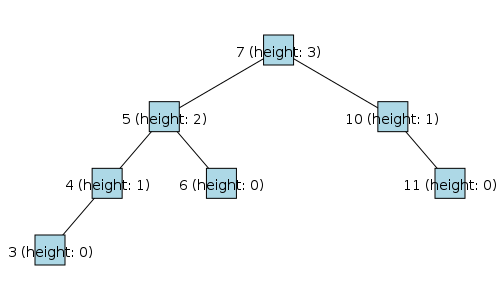

In [143]:
tree = BST()
for el in [7,5,4,6,3,10,11]:
    tree.insert(el)
tree.draw(display_height=True)

# AVL rotations

The only weapon of the lone worrior of the AVL clan is a rotation or to be more specific two rotations (the left rotation and the right rotation). 

Before we dive in the technical details of how to implement the AVL rotations let's first try to get some intuition. In AVL we strive to keep the difference between heights of right and left subtrees of all nodes at most $1$. Insertion can increase this difference to $2$ in the worst case.

For example imagine that we inserted an element into right subtree and now right subtree is 2 higher than left subtree. 

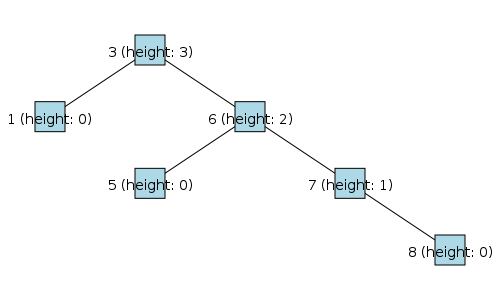

In [146]:
tree = BST()
for el in [3,1,6,5,7,8]:
    tree.insert(el)
tree.draw(display_height=True)

Intuitively what we want to do is to *rotate the tree left* - steal one node from right (and replace root by it) and add one node to the left subtree (the former root). Intuitively this will result in one decrase in right subtree height and one increase in left subtree height therefore balancing the tree (in reality it is not that simple, but that's just an intuition).

In [147]:
# HINT: when trying to understand this function read it from the bottom!

def AVL_rotate_left(node):
    """Rotates the tree left and returns a new root."""
    assert node.right is not None, \
            "Tree can only be rotated left if the right subtree is nonempty"
    old_right       = node.right
    old_right_left  = node.right.left
    
    # instead of old right node, old root takes old rights left subtree
    node.right     = old_right_left
    # node's children changed - we need to recompute the height
    node.recompute_height()
    
    # old root becomes left node of old right (which becomes new root) 
    old_right.left = node
    # old_right's children changed - we need to recompute the height
    old_right.recompute_height()
    
    return old_right

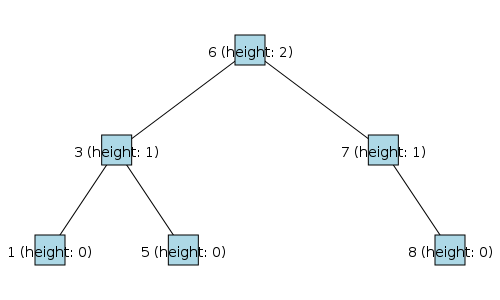

In [148]:
tree.root = AVL_rotate_left(tree.root)
tree.draw(display_height=True)

## Exercise: prove that AVL rotation preserves BST invariant

### AVL right rotation

The are analogous to left rotations (in fact they invert the left rotation)...

In [149]:
# HINT: when trying to understand this function read it from the bottom!

def AVL_rotate_right(node):
    """Rotates the tree right and returns a new root."""
    assert node.left is not None, \
            "Tree can only be rotated right if the left subtree is nonempty"
    old_left       = node.left
    old_left_right  = node.left.right
    
    node.left     = old_left_right
    node.recompute_height()
    
    old_left.right = node
    old_left.recompute_height()
    
    return old_left

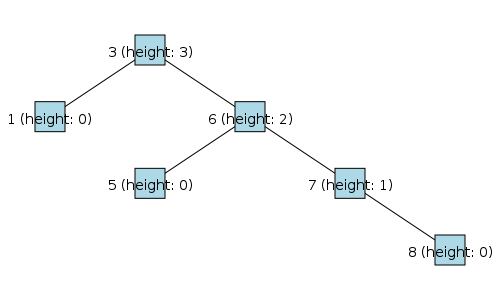

In [150]:
tree.root = AVL_rotate_right(tree.root)
tree.draw(display_height=True)

## AVL insertion prelude.

Assume we just performed insertion which threw our tree off balance. We will operate under recursive assumption, that child trees are balanced and that only current node maybe be unbalance (height of one child is height of second child + 2).

Intuition dictates that there are two cases to consider (left child higher or right child higher), but actually as we will soon find out there are four cases. Let's see why. 



### Case 1: Right-Right case 

First let's look at a simple tree where right subtree is higher.

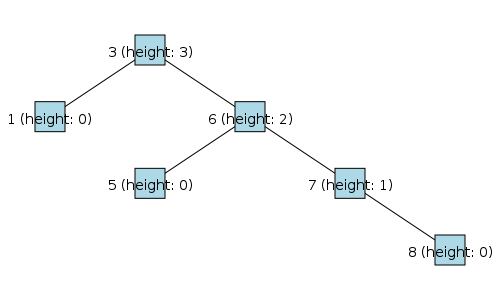

In [152]:
tree = BST()
for el in [3,1,6,5,7,8]:
    tree.insert(el)
tree.draw(display_height=True)

As we have already seen this can be fixed with a single left rotation.

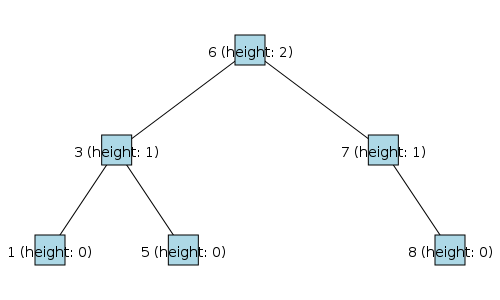

In [155]:
tree.root = AVL_rotate_left(tree.root)
tree.draw(display_height=True)

### Case 2: Right-Left case 
Let's look at the following bizzare example:

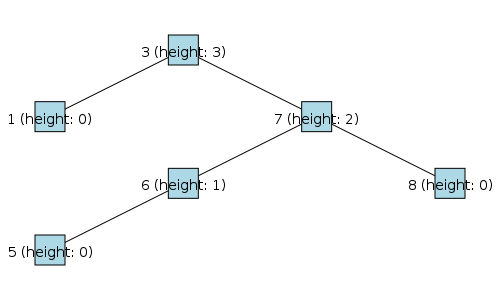

In [160]:
tree = BST()
for el in [3,1,7,6,5,8]:
    tree.insert(el)
tree.draw(display_height=True)

OBVIOUSLY* (as 6.006 progresses you will get more and more scared of this word) you can fix this with a left rotation.

*Not

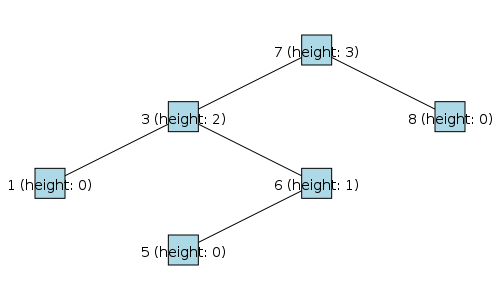

In [161]:
tree.root = AVL_rotate_left(tree.root)
tree.draw(display_height=True)

The tree is still unbalanced. What happened? 

Normally, for the *perfectly* blanced subtrees (balance factor of 0) left-rotation decreases hieght or right subtree by 1 and increases the height of the right subtree by 1.

Additionally the right-left subtree (the one rooted in 6 in the example) moves from right to left subtree. If that subtree is deepest (as in our example) it results in additional decrease by 1 for the right subtree and 1 increase in the left subtree. In which case the total balance is $-2$ for right subtree and $+2$ for left subtree, which means our tree is unblance again.

Notice that this situation only happens if right-left (root 6 in example) subtree is higher than right-right subtree (root 8 in our exmaple). Is there a way to cope with such a situation? You guessed it - we need to right-rotate the right subtree (then right-left subtree is not longer higher than right-right subtree and we land at the familiar Case 1: right right).

Let's see this in action!

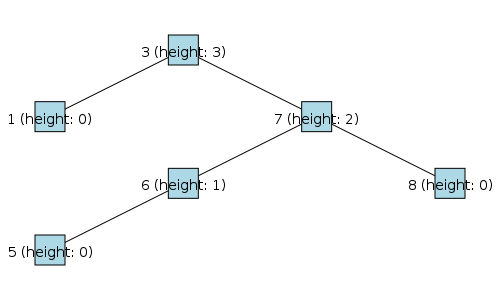

In [166]:
tree = BST()
for el in [3,1,7,6,5,8]:
    tree.insert(el)
tree.draw(display_height=True)

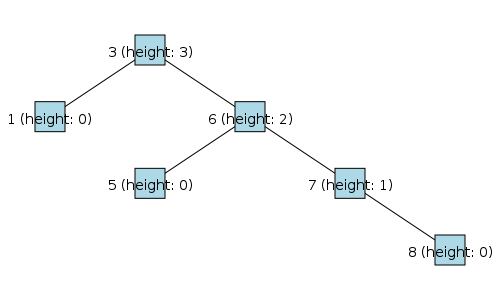

In [168]:
# Step 1:
tree.root.right = AVL_rotate_right(tree.root.right)
tree.root.recompute_height()
tree.draw(display_height=True)

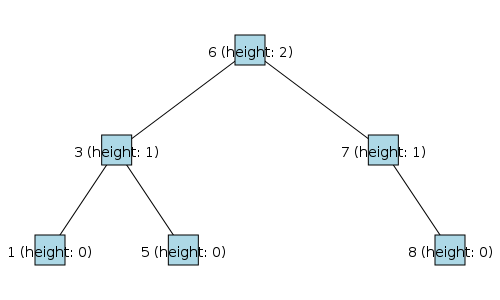

In [172]:
# Step 2:
tree.root = AVL_rotate_left(tree.root)
tree.draw(display_height=True)

### Cases 3 & 4: left-left and right-left

Those two cases are analogous to the cases 1 and 2, when the left tree is higher.